In [1]:
import base64
import collections
import copy
import cProfile
import datetime
import itertools
import json
import math
import os
import operator
import pickle
import random
import re
import shutil
import sys
import time

import bokeh
import cv2
import Image
import keras
from keras import *
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import prophet
import pyflux
import pylab
import scipy
import seaborn as sns
import skimage
import sklearn
from sklearn import *
import statsmodels as sm
import tensorflow as tf
import tqdm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
mpl.rcParams['figure.figsize'] = 20, 12
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

linewidth = 1.0
dotsize = 15

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/lo

# Load Time Series Data

In [2]:
d = pd.read_csv('data/AirQualityUCI.csv', sep=';', na_values=-200, nrows=24*7*4)
d.sample(20)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
171,17/03/2004,21.00.00,"5,7",1795.0,472.0,"27,2",1485.0,336.0,653.0,180.0,2174.0,2050.0,"19,1","42,6","0,9294",NaN,NaN
657,07/04/2004,03.00.00,"0,3",801.0,30.0,"0,7",464.0,NaN,1749.0,NaN,1154.0,340.0,"16,1","42,4","0,7718",NaN,NaN
526,01/04/2004,16.00.00,"2,3",NaN,319.0,"-200,0",NaN,131.0,NaN,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,02/04/2004,00.00.00,2,1139.0,157.0,"8,0",899.0,126.0,921.0,104.0,1514.0,1067.0,"14,1","54,4","0,8701",NaN,NaN
586,04/04/2004,04.00.00,NaN,1028.0,NaN,"3,5",682.0,NaN,1090.0,NaN,1448.0,697.0,"14,3","65,3","1,0594",NaN,NaN
283,22/03/2004,13.00.00,2,1102.0,NaN,"10,4",994.0,107.0,955.0,87.0,1599.0,783.0,"21,3","28,1","0,7067",NaN,NaN
102,15/03/2004,00.00.00,"1,8",1239.0,66.0,"7,4",872.0,104.0,985.0,99.0,1547.0,1250.0,"14,8","54,7","0,9164",NaN,NaN
112,15/03/2004,10.00.00,"5,8",1771.0,438.0,"26,6",1470.0,394.0,622.0,157.0,2262.0,1973.0,"17,4","45,6","0,8993",NaN,NaN
166,17/03/2004,16.00.00,"2,9",1365.0,193.0,"15,2",1154.0,186.0,940.0,129.0,1679.0,1221.0,"29,3","15,8","0,6309",NaN,NaN
124,15/03/2004,22.00.00,"3,2",1439.0,224.0,"15,3",1159.0,193.0,764.0,125.0,1856.0,1494.0,"15,7","60,2","1,0654",NaN,NaN


In [3]:
d.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object

In [4]:
d.index = pd.to_datetime(d.Date + ' ' + d.Time, format='%d/%m/%Y %H.%M.%S')

In [5]:
m1 = 'PT08.S4(NO2)'
m2 = 'PT08.S1(CO)'

In [6]:
train = d[m1].head(24*7*3)
test = d[m1].tail(24*7)

train2 = d[m2].head(24*7*3)
test2 = d[m2].tail(24*7)

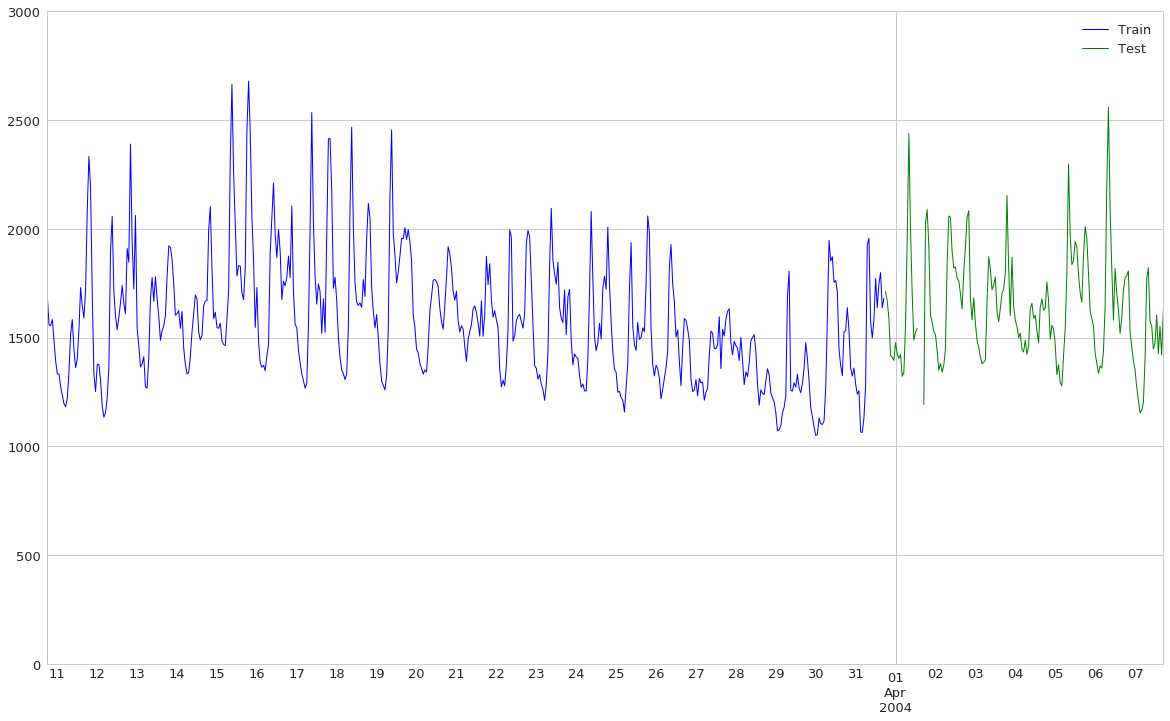

In [11]:
_ = train.plot(linewidth=linewidth, label='Train', legend=True, color='blue')
_ = test.plot(linewidth=linewidth, label='Test', legend=True, color='green')
_ = plt.ylim(0, 3000)